In [ ]:
#First go at implementing SVGD. View towards applying to BT sampling.

In [62]:
import torch
import math
import inspect

In [63]:
zdim=1
loc = torch.zeros(zdim,1)
cov_mat=torch.eye(zdim)
inv_cov_mat = torch.inverse(cov_mat)

Normal = torch.distributions.multivariate_normal.MultivariateNormal\
    (loc=loc, covariance_matrix=cov_mat, precision_matrix=None, scale_tril=None, validate_args=None)


In [64]:
Normal_density = lambda x: torch.exp(Normal.log_prob(x))
N=10
Particles = torch.rand(N,zdim,1) #so dim=2

In [7]:
#Array decorator to be used later

def array_decorator(f):
    
    def wrapper(X,*args,**kwargs):
        
        if len(X.shape)<=2: 
                
            return f(X,*args,**kwargs)
            
        N=X.shape[0]

        if 'z' in inspect.getfullargspec(f)[0]:
            
            z = kwargs['z']
            kwargs.pop('z', None)
            
            
            tem = [f(X[i],X[j],z=z[i,j],**kwargs) \
                for i in range(N) \
                for j in range(N)]

        else:
        
            tem = [f(X[i],X[j],**kwargs) \
                   for i in range(N) \
                   for j in range(N)]
       
        #Now we want to reshape the list of tensors tem to be NxNxd where d are dimensions of output of f
        d=tem[0] #Just grab the first entry. So this will be e.g. f(X[0],X[0],...)
        d=tuple(d.shape) #so e.g. this might be 2x1
        tem = torch.stack(tem,dim=0).view(N,N,*d) #Reshape
   
        return tem
    
    return wrapper


In [8]:
@array_decorator
def rbf(x,y,sig=1.0):
    """"Works for any dimensionality
    """
    
    assert(sig>0)
    v = (-1/(2*sig))*torch.linalg.vector_norm(x-y)**2
    return torch.exp(v)
    

In [9]:
rbf(Particles[0],Particles[1])

x=torch.tensor([0.,1.])
y=torch.tensor([0.,4.])
torch.linalg.vector_norm(x-y)
assert rbf(x,y) == torch.exp(-0.5*torch.tensor([9.]))

In [10]:
@array_decorator
def dist(x,y):
    
    return torch.norm(x-y)

In [11]:
#Test
x=torch.tensor([1.,0])
y=torch.tensor([2.,1])
assert (dist(x,y) == (2**0.5))

Particles = 10*torch.rand(10,3,1)-10 #so zdim=3

assert dist(Particles)[2,3] == torch.norm(Particles[2]-Particles[3])


In [12]:
tem=dist(Particles)
print(torch.mean(tem))
print(torch.median(tem))

tensor(6.5084)
tensor(7.0486)


In [13]:
#TODO: Rewrite these tests with pytest!

#2d
x=torch.ones(2,1)
y=torch.zeros(2,1)
assert(abs(rbf(x,y,sig=1) - 0.36787944117144233)<1e-4)

#NOTE: Writing this out twice is redundant!!

#2d
x=torch.tensor([[1.],[2.]])
y=torch.tensor([[0.],[1.]])
sig=0.5
assert(abs(rbf(x,y,sig=sig) - math.exp(-2)) < 1e-4)

#1d
x = torch.tensor([[4.]])
y = torch.tensor([[2.]])
sig=1
assert(abs(rbf(x,y,sig=sig) - math.exp(-2)) < 1e-4)

#TODO: Array
#Notice redundancy here!

X = torch.rand(10,2,1)

x1,y1 = X[0],X[4]
sig=0.02
V1 = rbf(X,sig=sig)
assert((rbf(x1,y1,sig=sig) == V1[0,4]).item())


x2,y2 = X[0],X[4]
sig=1.2
V2 = rbf(X,sig=sig)
assert((rbf(x2,y2,sig=sig) == V2[0,4]).item())





In [14]:
#So function that operates on rows can operate on collection together

#i.e. if we apply this decorator to functions that work on, in our case zdim x 1 arrays, e.g. the score function
#now we can apply them "batch wise" across N x zdim x 1 arrays, by simply applying the decorator!

def row_decorator(f):
    
    def wrapper(X):
        
        #If this condition holds reduces to old case
        if len(X.shape)==2:
            return f(X)
        
        N=X.shape[0]
    
        return torch.stack([f(X[i]) for i in range(N)])
    
    return wrapper 

In [15]:
#Need gradient of log_density, or score function, for N(zdim)

@row_decorator
def score(x):
    tem = -1*torch.mm(inv_cov_mat,x-loc) #Works independently of dimension!
    
    assert(tem.shape[1]==1)
    
    return tem

In [16]:
#Test above function. Relies on being standard 2d case
x=torch.rand(zdim,1)
score(x)

assert(torch.all(score(x)==-x)) #test default behaviour

#row test
Particles = torch.rand(10,zdim,1) #Relies on being zdim

assert(torch.all(score(Particles)[4] == score(Particles[4]))) #Test decorator extension, i.e. @row_decorator



In [17]:
#Need gradient of kernel wrt FIRST argment

#Grad kernel works just passing in x,y,sig, OR if pass in, additionally, x,y,sig and array of
#precomputed rbf_xy with an index i,j that corresponds to rbf_xy[i,j,sig]=rbf(x,y,sig)
@array_decorator
def grad_kernel(x,y,z=None,sig=1.0):
    """"Since gradient of kernel depends on z=rbf(x,y) we just compute it once 
        elsewhere and pass it in here. IMPORTANT: Computed wrt first argument x. 
    """
    
    #Instead of Particles[i],Particles[j] we now want Particles[i],Particles[j],rbf_xy[i,j]
    if z is None:
        z = rbf(x,y,sig=sig)

    return (-1/sig)*z*(x-y)
    
    #syntax of decorator: dec(grad_kernel(X,...)) = grad_kernel(X[i],X[j],...)
  
    #g = (-1/sig)*rbf_xy*(x-y) formula given all the values. 
    


In [18]:
#TODO: Test more. But note that also need to make sure gradient computations are correct!!!
#Test
x=torch.tensor([[1.],[2.]])
y=torch.tensor([[0.],[1.]])
sig=0.5

rbf_xy = rbf(x,y,sig=sig)
grad_kernel(x,y,z=rbf_xy,sig=sig) #Make sure runs
#input()

#Higher dimensional test
rbf_xy = rbf(Particles,sig=sig)
assert(torch.all(grad_kernel(Particles[3],Particles[4],z=rbf_xy[3,4],sig=sig)==grad_kernel(Particles,z=rbf_xy,sig=sig)[3,4])) #woohoo, seems to work!!!



In [19]:
#Now have 1,2,3 so essentially have phi

def phi(Particles,N,sig):
    
    K = rbf(Particles,sig=sig) #kernel

    S = score(Particles).view(N,-1) #score
    
    DK = grad_kernel(Particles,z=K,sig=sig).view(N,N,-1) #derivative of kernel
 
        
            #First term             #Second term
    return (1/N)*(torch.mm(K.T,S) + torch.sum(DK,axis=0)).view(N,-1,1)



In [20]:
K = rbf(Particles,sig=sig) #kernel
DK = grad_kernel(Particles,z=K,sig=sig).view(N,N,-1) #derivative of kernel


X=torch.rand(3,3)
print(X.sum(0))
print(X.sum(1))
print(X)
print(torch.sum(X,axis=0)) #Sum rows
print(torch.sum(X,axis=1)) #Sum cols




tensor([2.2314, 1.2380, 0.8986])
tensor([1.0921, 1.9037, 1.3722])
tensor([[0.8599, 0.0735, 0.1587],
        [0.5262, 0.9087, 0.4689],
        [0.8454, 0.2558, 0.2710]])
tensor([2.2314, 1.2380, 0.8986])
tensor([1.0921, 1.9037, 1.3722])


In [21]:
def SVGD(Particles,N,sig,eta=0.01):
    return Particles + eta*phi(Particles,N,sig)

In [22]:
def Adam_SVGD(Particles,g,m=None,v=None,eta=1e-3,beta1=0.9,beta2=0.999,eps=1e-8):
    
    #Initialization of m and v
    if m is None:
        
        m=0*g
        v=0*g
        
    m = beta1*m + (1-beta1)*g
    v = beta2*v + (1-beta2)*g.pow(2)
    
    mhat = m/(1-beta1)
    vhat = v/(1-beta2)
    
    
    Particles = Particles + eta/(vhat.pow(0.5) + eps) * mhat
    
    return Particles,m,v
    
    

In [23]:
tem=Normal.rsample(sample_shape=torch.Size([15]))
print(tem.max())
print(tem.min())
print(tem.mean())

tensor(0.7552)
tensor(-2.1168)
tensor(-0.3081)


In [25]:
#import snakeviz

%load_ext snakeviz
import numpy as np

The snakeviz extension is already loaded. To reload it, use:
  %reload_ext snakeviz


In [61]:
#Comparison of ways to compute rbf kernel

#My way:

S=0
for n in range(10):
    t1=time()
    Particles = torch.rand(500,zdim,1)
    K = dist(Particles)
    t2=time()
    print(t2-t1)


4.612829208374023


In [50]:
from time import time

In [ ]:
#Method 1: With some vectorization

#Use fact that ||x-y||^2 = ||x||^2 + ||y||^2 - - 2 * x^T * y

In [ ]:
X_norm = np.sum(X ** 2, axis = -1)

K = var * np.exp(-gamma * (X_norm[:,None] + X_norm[None,:] - 2 * np.dot(X, X.T)))

In [55]:
#TODO: Profile where code is slow and make it faster
#import cProfile

def main():

    N=100
    Particles = torch.rand(N,zdim,1)
    #sig=2
    #L=100
    L=1
    eta=0.1

    #Initialize m and v 
    m=None
    v=None

    for l in range(L):

        #print('About to get pairwise distance')
        #t1=time()
        d = dist(Particles) #Get pairwise distance
        #t2=time()
    #     print((t2-t1))
    #     print('Got pairwise distance in {}s'.format((t2-t1)))
    #     input()

        sig = 0.5*torch.median(d)**2 / math.log(N) #Adaptively
        #sig = 1.0

        #print('about to run phi')
        #t1=time()
        g = phi(Particles,N,sig)
        #t2=time()
        #print('Ran phi in {}'.format((t2-t1)))

        #input()
        Particles,m,v = Adam_SVGD(Particles,g=g,m=m,v=v,eta=eta)

        if l == 250:
            eta=0.01

        elif l == 500:
            eta=0.001

        #print(l)

        #print(torch.max(Particles))
        #print(torch.min(Particles))


        #Particles = SVGD(Particles,N,sig=sig,eta=eta) #How to choose step size?

        #print(Particles)

# print(torch.max(Particles))
# print(torch.min(Particles))
# print(torch.mean(Particles))


%snakeviz main()

 
*** Profile stats marshalled to file '/var/folders/95/qkdymsl93lz1tvnqky1vn_p00000gn/T/tmph1tk7ytw'. 
Embedding SnakeViz in this document...


In [319]:
import numpy as np
np.histogram([1, 2, 1], bins=[0, 1, 2, 3])

(array([0, 2, 1]), array([0, 1, 2, 3]))

In [427]:
import seaborn as sns
import numpy as np
data=Particles.detach().numpy()
data=np.reshape(data,N)
data=np.sort(data)


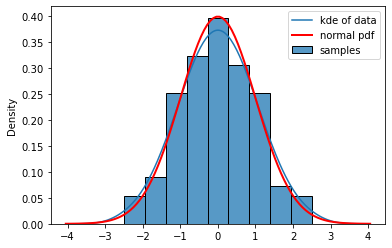

In [428]:
#Useful code cell
import scipy
x = np.random.standard_normal(1000)

#ax = sns.histplot(x, kde=False, stat='density', label='samples')
ax = sns.histplot(data, kde=False, stat='density', label='samples')

sns.kdeplot(data,label='kde of data')

# calculate the pdf
x0, x1 = ax.get_xlim()  # extract the endpoints for the x-axis
x_pdf = np.linspace(x0, x1, 100)
y_pdf = scipy.stats.norm.pdf(x_pdf)

ax.plot(x_pdf, y_pdf, 'r', lw=2, label='normal pdf')                                                   
ax.legend()

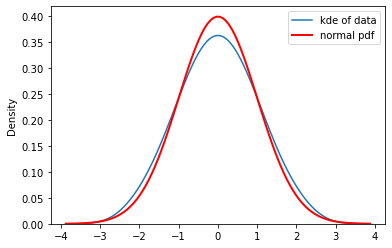

In [388]:
ax = sns.kdeplot(data,label='kde of data')
x0, x1 = ax.get_xlim()  # extract the endpoints for the x-axis
x_pdf = np.linspace(x0, x1, 100)
y_pdf = scipy.stats.norm.pdf(x_pdf)

ax.plot(x_pdf, y_pdf, 'r', lw=2, label='normal pdf')                                                   
ax.legend()
